# Model 4 Training Environment

Model 4 contains major posiitive changes from Model 3.

The key improvement from model three is the removal of the similarity function and thresholding from inside model architecture. Meaning that the model no longer outputs a single binary classsification derived from applying a similarity function to the input img's vector embeddings. Instead, the model now outputs those 2 vector embeddings. 

This was a major architectural improvement! The reason being that outputting a single binary value meant that I was not actually training a siamese network, but a sort of convoluded CNN classifier. It also freed up that similarity function to be used AS the loss function (as opposed to BCE, which I was using in modle 3). This resulted in the gradients being able to properly inform whether the vector embeddings were improving as representations of the input images. I thank https://github.com/seanbenhur/siamese_net/blob/master/siamese-net for the idea to make these changes. 

# 1.) 

Here I am importing the Wrangler class from data_wrangler.py, which will process the raw data into it's model trainable format. 

In [1]:
from data_wrangler import Wrangler

wrangler = Wrangler(op_sys="linux", binary=False, reshape_size=(112, 112))

train_dir = r"testtest"
test_dir = r"traintrain"

train_imgs, train_labels, test_imgs, test_labels = wrangler.main(train_dir, test_dir)

/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Dataset Shapes

In [2]:
print(f"train_imgs shape: {train_imgs.shape}")
print(f"train_labels shape: {train_labels.shape}")
print(f"test_imgs shape: {test_imgs.shape}")
print(f"test_labels shape: {test_labels.shape}")

train_imgs shape: torch.Size([885, 1, 112, 112])
train_labels shape: torch.Size([885])
test_imgs shape: torch.Size([254, 1, 112, 112])
test_labels shape: torch.Size([254])


Below is a plot of 2 processed images, ready for training.

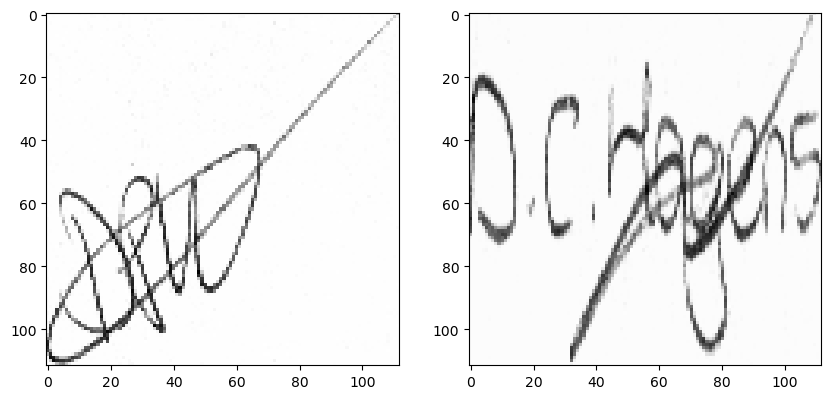

In [3]:
import matplotlib.pyplot as plt
import numpy as np


def plot_imgs(img_tensor_1, image_tensor_2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(img_tensor_1.detach().numpy(), cmap='gray')
    ax[1].imshow(image_tensor_2.detach().numpy(), cmap='gray')
    plt.show()

plot_imgs(train_imgs[233].squeeze(0), 
          train_imgs[12].squeeze(0))

Below I am wrapping the two data splits into tensor dataset objects, which groups their img and label tensors appropriatetly. Then wrapping them in dataloaders for training.

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(train_imgs, train_labels)
test_dataset = TensorDataset(test_imgs, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2.)
Here I am loading in the autoencoder model and setting the hyperparameters.

NOTE: initial_channel_increase refers to the channel increase for the first convolution block from the input image. channel_increase_factor refers to the factor by which subsequent conv blocks increase the channel size.

In [5]:
from model_4 import SiameseNet

model = SiameseNet(input_shape = (1, 112, 112), 
                    embedding_size = 64,
                    initial_channel_increase=32, 
                    channel_increase_factor=2
                    )

Below is an example forward pass with the shapes of the inptus and oputputs printed out.

In [6]:
image_1 = train_imgs[0].unsqueeze(0)
image_2 = train_imgs[1].unsqueeze(0)


print(f'Input image shape: {image_1.shape}')
print(f'Input image shape: {image_2.shape}')

model.to('cpu')

embedding_1, embedding_2 = model(image_1, image_2)

print(f'Embedding of image 1 shape: {embedding_1.shape}')
print(f'Embedding of image 2 shape: {embedding_2.shape}')

Input image shape: torch.Size([1, 1, 112, 112])
Input image shape: torch.Size([1, 1, 112, 112])
Embedding of image 1 shape: torch.Size([1, 64])
Embedding of image 2 shape: torch.Size([1, 64])


Printed below are the total parameters of the model.

In [7]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total Params: {total_params:,}")

Total Params: 1,893,024


# 3.) 
Here I am instantiaing the Trainer class and setting up its hyperparameters. 

The loss funciton being used is contrastive loss, which is a measure of vector embedding similarity that incorporates binary labels of similairty status. 

L(x_1, x_2, y) = (y - 1) * Dw(x_1, x_2)^2 + y * max(0, m - Dw(x_1, x_2)^2)

Where: 
- x_1 and x_2 are vector embeddings
- y is a binary classification of their similarity
- Dw(x_1, x_2)^2 is euclidian distance
- m is the margin hyperparameter which sets the minimum
- euclidian distance between embeddings

In [8]:
from train import Trainer
import torch
from contrastive import ContrastiveLoss

epochs = 1000
patience = 20

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

criterion = ContrastiveLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


trainer = Trainer(model=model,
                    optimizer=optimizer,
                    criterion=criterion,
                    device=device,
                    epochs=epochs,
                    patience=patience,
                    train_loader=train_loader,
                    val_loader=test_loader)

Using device: cuda


Below I am calling the .train() method of the trianer. 

NOTE: best_model is a torch state dict

In [ ]:
best_model, val_loss, train_loss = trainer.train()

torch.save(best_model.state_dict(), 'model_4.pth')

# 5.) 
Below are the learning curves for trian and validation contrastive loss. The y label says BCE loss, but this is not correct. 

I am a bit unsure why the train loss is so volatile. However, the validation loss converged nicely, and this is a more important metric.

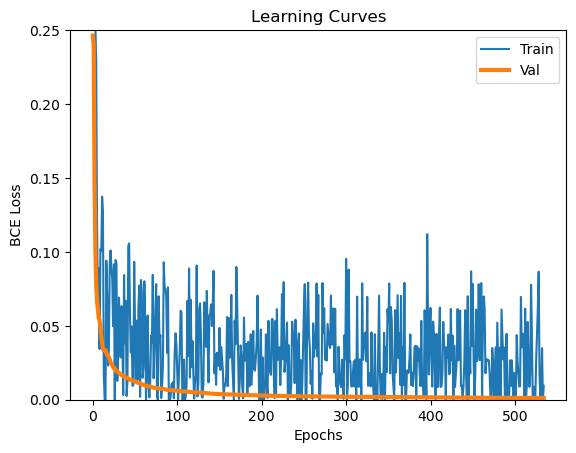

In [19]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_loss, val_loss):
    # plot curves
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Val", linewidth=3)
    plt.legend()
    plt.ylim(0, 0.25)
    
    # labels
    plt.xlabel("Epochs")
    plt.ylabel("BCE Loss")
    
    plt.title("Learning Curves")
    
plot_learning_curves(train_loss, val_loss)